In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

In [2]:
# Login
from login import username, password
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user(username, password)

if not status:
    print(msg)
else:
    print('You are logged in!')

You are logged in!


In [3]:
dataset_name = 'district.csv'
df = pd.read_csv(dataset_name)
df.head()
print(df.shape)

(1203, 107)


In [4]:
df = df[['DZRATING', 'DZCAMPUS','DPETALLC','DA0AT16R','DA0912DR16R','DAGC4X16R','DAGC5X15R','DAGC6X14R','DA0GR16N','DA0CT16R','DA0CC16R','DA0CSA16R','DA0CAA16R','DPSTTOSA','DPSTEXPA','DPFRAALLT','DPFRAALLK','DPFRASTAP','DZRVLOCP','DPFRAFEDP','DPFEAINST','DPFEAINSK','DISTSIZE','COMMTYPE', 'PROPWLTH', 'TAXRATE']]
df = df.rename(index=str, columns = {"DZRATING":"rating", "DZCAMPUS":"num_schools", "DPETALLC":"num_students", "DA0AT16R":"attendance_rate", "DA0912DR16R":"dropout_rate", "DAGC4X16R":"grad_rate_4_year", "DAGC5X15R":"grad_rate_5_year", "DAGC6X14R":"grad_rate_6_year", "DA0GR16N":"annual_grad_count", "DA0CT16R":"college_admissions_per_tested", "DA0CC16R":"college_admissions_at_crit", "DA0CSA16R":"average_sat", "DA0CAA16R":"average_act", "DPSTTOSA":"average_teacher_salary", "DPSTEXPA":"average_teacher_exp", "DPFRAALLT":"total_revenue", "DPFRAALLK":"total_revenue_per_pupil", "DPFRASTAP":"percent_revenue_from_state", "DZRVLOCP":"percent_revenue_from_local", "DPFRAFEDP":"percent_revenue_from_federal", "DPFEAINST":"instr_expenditures", "DPFEAINSK":"instr_expenditures_per_pupil", "DISTSIZE":"district_size", "COMMTYPE":"community_type", "PROPWLTH":"property_wealth", "TAXRATE":"tax_rate"})
df.head()

,rating,num_schools,num_students,attendance_rate,dropout_rate,grad_rate_4_year,grad_rate_5_year,grad_rate_6_year,annual_grad_count,college_admissions_per_tested,...,total_revenue_per_pupil,percent_revenue_from_state,percent_revenue_from_local,percent_revenue_from_federal,instr_expenditures,instr_expenditures_per_pupil,district_size,community_type,property_wealth,tax_rate
0,Met Standard,3,576,96.8,1,93.5,96.6,89.2,45,60,...,15318,40.4,38.6,21,4750155,8363,500 to 999,Rural,"$450,288 to < $512,741",Under $1.1659
1,Met Standard,4,1267,96.6,0.3,98.6,98.6,98.7,74,56.8,...,9887,61.2,32.9,5.9,6535726,5254,"1,000 to 1,599",Non-metropolitan Stable,"$226,182 to < $235,915",$1.2781 to under $1.3998
2,Met Standard,3,846,96.2,0.4,100,100,100,50,38,...,11153,50.7,43.2,6.1,4099594,4875,500 to 999,Rural,"$297,485 to < $318,066",$1.3998 and over
3,Met Standard,2,377,96.4,0,94.3,96.9,97.6,35,60,...,10892,56.7,36.3,7.1,2190799,5720,Under 500,Rural,"$297,485 to < $318,066",$1.2781 to under $1.3998
4,Met Standard,6,3453,95.7,0.2,89.2,96.8,97.8,178,32,...,12311,43.4,42.8,13.8,18198163,5376,"3,000 to 4,999",Independent Town,"$276,039 to < $297,485",$1.3998 and over


In [5]:
df[0:len(df)//5].to_csv('test_data.csv')
df[len(df)//5:].to_csv('train_data.csv')

In [6]:
TRAIN_DATASET='train_data.csv'
TEST_DATASET = 'test_data.csv'
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
status, dataset = ds.upload_dataset( TRAIN_DATASET)
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



In [7]:
#clean train_Set
target = "rating"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-13T13:54:12.625879', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['a47dc116bab44a1fa386d9da7a03b7b6'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-13T13:54:12.625879', 'endtime': '2019-04-13T13:54:15.653648', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['a47dc116bab44a1fa386d9da7a03b7b6'], 'model_name': None, 'job_error': ''}


In [8]:
model = target + "_model01" + ts
status, job_id = ds.create_model(dataset_names = TRAIN_DATASET, \
                                 model_name =  model, \
                                 max_train_time = '00:05')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-13T13:54:28.904331', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190413135410', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-13T13:54:28.904331', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190413135410', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-13T13:54:28.904331', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': ['train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190413135410', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-13T13:54:28.904331', 'endtime': None, 'percent_complete': 10, '

In [9]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Running', 'starttime': '2019-04-13T13:56:30.594146', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': None, 'artifact_names': ['1100f9fc9fd747d3891ea745fa21ba46'], 'model_name': 'rating_model0120190413135410', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-13T13:56:30.594146', 'endtime': '2019-04-13T13:56:32.04474', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': None, 'artifact_names': ['1100f9fc9fd747d3891ea745fa21ba46'], 'model_name': 'rating_model0120190413135410', 'job_error': ''}


In [10]:
feature_importance[:10]

attendance_rate                  0.091801
instr_expenditures_per_pupil     0.069590
average_teacher_exp              0.067306
num_students                     0.061547
grad_rate_5_year                 0.058105
college_admissions_per_tested    0.056559
percent_revenue_from_state       0.055458
grad_rate_6_year                 0.050457
dropout_rate                     0.049914
grad_rate_4_year                 0.044283
dtype: float64

In [11]:
status, artifact = ds.run_model(TRAIN_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-13T13:56:48.196114', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': ['train_data.csv'], 'artifact_names': ['6849e722d6a64506af7feca651f939f7'], 'model_name': 'rating_model0120190413135410', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-13T13:56:48.196114', 'endtime': '2019-04-13T13:56:49.447322', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': ['train_data.csv'], 'artifact_names': ['6849e722d6a64506af7feca651f939f7'], 'model_name': 'rating_model0120190413135410', 'job_error': ''}


(True, 'Job completed')

In [12]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,prob_Improvement Required,prob_Met Alternative Standard,prob_Met Standard,prob_Not Rated,rating
0,0.000839,0.000095,0.998949,0.000118,Met Standard
1,0.007248,0.000843,0.989734,0.002175,Met Standard
2,0.003129,0.000278,0.996328,0.000265,Met Standard
3,0.006836,0.000804,0.991411,0.000948,Met Standard
4,0.000960,0.000202,0.998686,0.000152,Met Standard


In [13]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

ValueError: operands could not be broadcast together with shapes (963,) (1203,) (963,) 

In [14]:
#TEST DATASET
status, dataset = ds.upload_dataset( TEST_DATASET)
if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



In [15]:
status, job_id = ds.clean_data(TEST_DATASET, target = target, model_name = model)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-13T13:58:29.885537', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['d2c3b81758d141b48c72158e740ebd86'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-13T13:58:29.885537', 'endtime': '2019-04-13T13:58:31.319168', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['d2c3b81758d141b48c72158e740ebd86'], 'model_name': None, 'job_error': ''}


In [16]:
status, artifact = ds.run_model(TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-13T13:58:46.15341', 'endtime': '2019-04-13T13:58:47.134996', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.7967410683631897, 'generations': 7, 'dataset_names': ['test_data.csv'], 'artifact_names': ['2e32b02c36fd4350a2a65271da418096'], 'model_name': 'rating_model0120190413135410', 'job_error': ''}


(True, 'Job completed')

                          precision    recall  f1-score   support

    Improvement Required       0.00      0.00      0.00         8
Met Alternative Standard       0.80      0.67      0.73         6
            Met Standard       0.96      0.99      0.97       225
               Not Rated       0.00      0.00      0.00         1

             avg / total       0.92      0.95      0.93       240



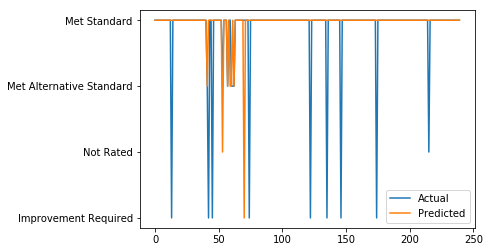

In [17]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(TEST_DATASET)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))